In [11]:
import sys

import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import seaborn as sns

from netam import framework, models
from netam.common import print_parameter_count

sys.path.append("..")
from shmex.shm_data import train_val_dfs_of_nickname

In [55]:
s5f = models.RSFivemerModel(kmer_length=5)
mutability_df = pd.read_csv("../data/HS5F_Mutability.csv")
mutability_df.index = [s5f.all_kmers.index(kmer) for kmer in mutability_df["Fivemer"]]
mutability_df.sort_index(inplace=True)
mutability_df

mean_mutability = mutability_df["Mutability"].mean()
mutability_array = np.concatenate([[mean_mutability], mutability_df["Mutability"]])
assert s5f.r_kmer_embedding.weight.shape[0] == mutability_array.shape[0]
s5f.r_kmer_embedding.weight.data = torch.tensor(np.log(mutability_array)).float().unsqueeze(0)

subs_df = pd.read_csv("../data/HS5F_Substitution.csv")
subs_df.index = [s5f.all_kmers.index(kmer) for kmer in subs_df["Fivemer"]]
subs_df.sort_index(inplace=True)
subs_array = np.concatenate([
    [[0., 0., 0., 0.]],
    np.log(subs_df[["A", "C", "G", "T"]].to_numpy() + 1e-100)
])
assert s5f.s_kmer_embedding.weight.shape == subs_array.shape
s5f.s_kmer_embedding.weight.data = torch.tensor(subs_array).float()

s5f_crepe = framework.Crepe(framework.KmerSequenceEncoder(kmer_length=5, site_count=500), s5f)
s5f_crepe.save("../train/fixed_models/s5f")

In [ ]:
train_df, val_df = train_val_dfs_of_nickname("shmoof_small")
# train_df, val_df = train_val_dfs_of_nickname("cui")

In [47]:
kmer_length = 5
site_count = 500

train_dataset = framework.SHMoofDataset(train_df, kmer_length=kmer_length, site_count=site_count)
val_dataset = framework.SHMoofDataset(val_df, kmer_length=kmer_length, site_count=site_count)

print(f"we have {len(train_dataset)} training examples and {len(val_dataset)} validation examples")

we have 46391 training examples and 2625 validation examples


In [ ]:
model = models.FivemerModel()
burrito = framework.SHMBurrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, l2_regularization_coeff=1e-7)
print_parameter_count(model)
print("starting training...")
losses = burrito.train(epochs=100)
burrito.save_crepe("../pretrained/fivemer")
losses.tail()

kmer_embedding: 1025 parameters
-----
total: 1025 parameters
starting training...


Epoch: 100%|██████████| 100/100 [01:21<00:00,  1.22it/s, loss_diff=5.551e-07, lr=0.00313, val_loss=0.05072]


,train_loss,val_loss
96,0.044743,0.050719
97,0.044745,0.050717
98,0.044744,0.050717
99,0.044739,0.050719
100,0.044747,0.050720


Training with regularization coefficient 0


Epoch: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s, loss_diff=-4.321e-07, lr=0.0125, val_loss=0.05078]


Training with regularization coefficient 1e-08


Epoch: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s, loss_diff=-2.582e-06, lr=0.0125, val_loss=0.05074]


Training with regularization coefficient 1e-07


Epoch: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s, loss_diff=1.684e-06, lr=0.0125, val_loss=0.05072] 


Training with regularization coefficient 1e-06


Epoch: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s, loss_diff=-1.363e-05, lr=0.0125, val_loss=0.05073]


Training with regularization coefficient 1e-05


Epoch: 100%|██████████| 50/50 [00:42<00:00,  1.19it/s, loss_diff=7.644e-06, lr=0.0125, val_loss=0.05137]


Training with regularization coefficient 0.0001


Epoch: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s, loss_diff=-3.058e-06, lr=0.0125, val_loss=0.05344]


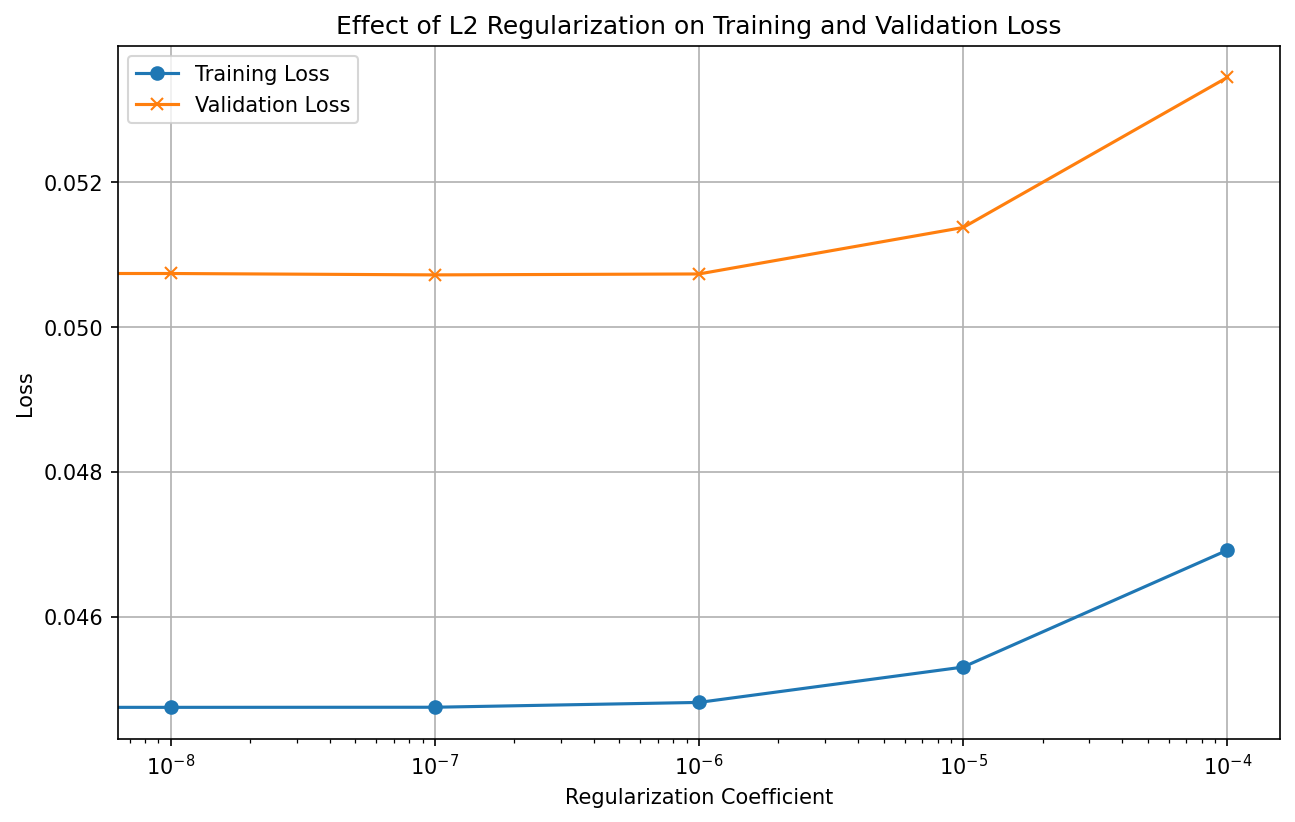

In [5]:
regularization_coeffs = [0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
results = []

for coeff in regularization_coeffs:
    print(f"Training with regularization coefficient {coeff}")
    model = models.FivemerModel()
    burrito = framework.SHMBurrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, l2_regularization_coeff=coeff)
    loss_history = burrito.train(epochs=50)
    final_training_loss = loss_history['train_loss'].iloc[-1]
    final_validation_loss = loss_history['val_loss'].iloc[-1]

    results.append({
        'Regularization': coeff,
        'Final_Training_Loss': final_training_loss,
        'Final_Validation_Loss': final_validation_loss
    })

regularization_results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Training_Loss'], label='Training Loss', marker='o')
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Validation_Loss'], label='Validation Loss', marker='x')

plt.xscale('log')
plt.xlabel('Regularization Coefficient')
plt.ylabel('Loss')
plt.title('Effect of L2 Regularization on Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
regularization_results_df

,Regularization,Final_Training_Loss,Final_Validation_Loss
0,0.000000e+00,0.044750,0.050775
1,1.000000e-08,0.044750,0.050737
2,1.000000e-07,0.044752,0.050718
3,1.000000e-06,0.044818,0.050731
4,1.000000e-05,0.045306,0.051372
5,1.000000e-04,0.046919,0.053443
